# Random Fourier Features

*You are seeing the
notebook output generated by
[Literate.jl](https://github.com/fredrikekre/Literate.jl) from the
[Julia source file](https://github.com/JuliaGaussianProcesses/KernelSpectralDensities.jl/blob/main/examples/2-features/script.jl).
The rendered HTML can be viewed [in the docs](https://juliagaussianprocesses.github.io/KernelSpectralDensities.jl/dev/examples/2-features/).*

One of the reasons to be interested in the spectral density of a kernel is
that it allows us to approximate a GP Prior.
In this notebook we show the two feature functions implemented in KernelSpectralDensities.jl
and how to use them.

**Load required packages**

In [1]:
using KernelSpectralDensities
using StatsBase
using LinearAlgebra
using CairoMakie
using DisplayAs #hide

## Intro
In general, feature functions allow us to project an input into a higher-dimensional space,
which is useful for a variety of tasks.
For example, we can use them to approximate a kernel using the "kernel trick".

A special class of feature functions are "random Fourier features", derived from
the Fourier transform, which we saw in add link from other example.
KernelSpectralDensities implements two types of random Fourier features,
`ShiftedRFF` and `DoubleRFF`.

For this example we use the simple squared exponential kernel.

In [2]:
ker = SqExponentialKernel()
S = SpectralDensity(ker, 1);

## ShiftedRFF
The `ShiftedRFF` feature function is somewhat more common, and has
been used in papers such as [Efficiently sampling functions from Gaussian process posteriors](https://proceedings.mlr.press/v119/wilson20a.html).
It is defined as
$$
    \varphi_i(x) = \sqrt{2 / l}  \cos(2  π  ((w_i^T  x) + b_i))
$$
where $w_i$ is sampled from the spectral density $S$,
$b_i$ is uniformly sampled from $[0, 2π]$
and $l$ is the number of sampled frequencies, which is also
the number of features.

We generate a set of 4 feature functions, which we can evaluate
at any point.

In [3]:
srff = ShiftedRFF(S, 4)
srff(1.0)

4-element Vector{Float64}:
 -0.678811244277198
 -0.07379871172304092
 -0.5752271467160547
 -0.3316998113692027

If we plot them, we see that each feature function is a harmonic
with varying frequency and phase.

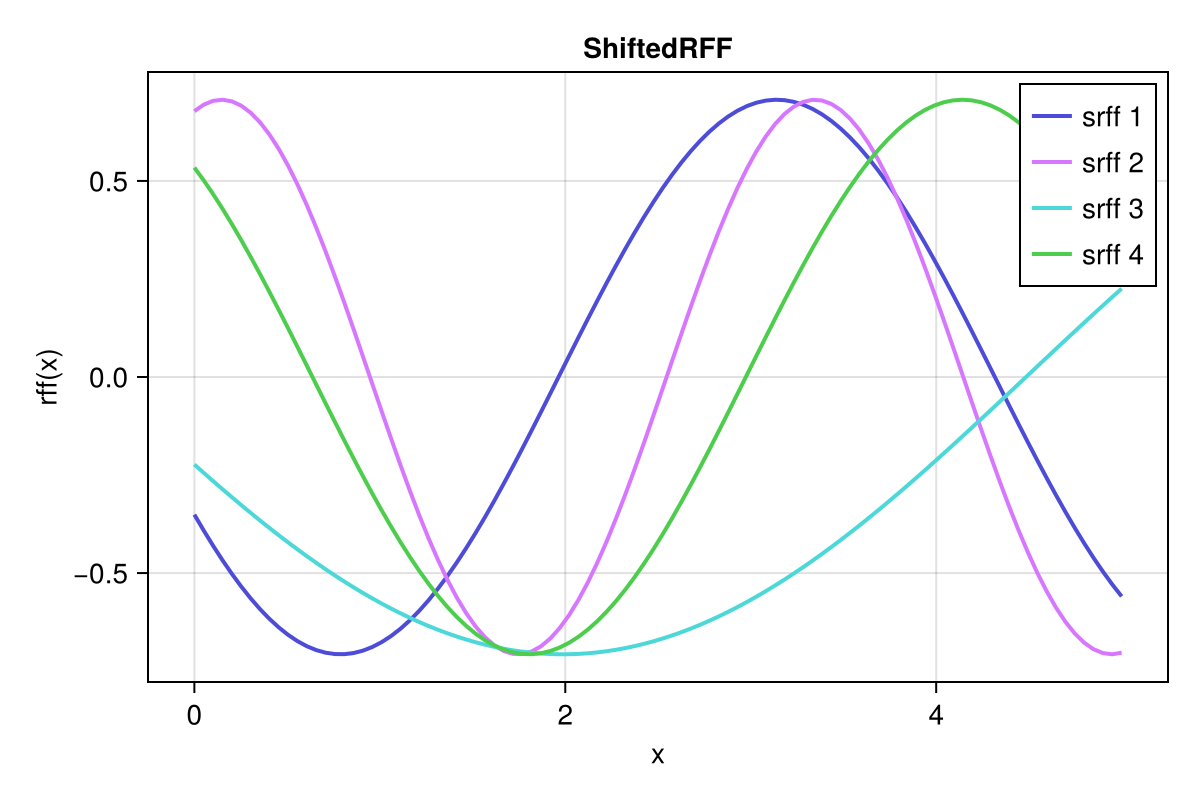

In [4]:
x = range(0, 5; length=100)
f = Figure(; size=(600, 400))
ax = Axis(f[1, 1]; xlabel="x", ylabel="rff(x)", title="ShiftedRFF")
series!(ax, x, reduce(hcat, srff.(x)); labels=["srff $i" for i in 1:4])
axislegend(ax; position=:rt)
f

## DoubleRFF
The `DoubleRFF` feature function is less common, but is theoretically
equivalent to the `ShiftedRFF` feature function.
It is defined as
$$
    \varphi(x) = \sqrt{1 / l} \begin{pmatrix} \cos(2 π w' x) \\ \sin(2 π w' x) \end{pmatrix}
$$
where $w'$ is sampled from the spectral density $S$,
with a total of $l/2$ sampled frequencies.
Here, each function is effectively two feature functions in one,
so specifying $l$ will result in $l/2$ samples but an $l$ dimensional
feature vector.

We again generate a set of 4 feature functions.

In [5]:
drff = DoubleRFF(S, 4)
drff(1.0)

4-element Vector{Float64}:
  0.6932661920534857
  0.35352779445995697
 -0.13921920469410634
  0.6123872129170224

We plot these features as well

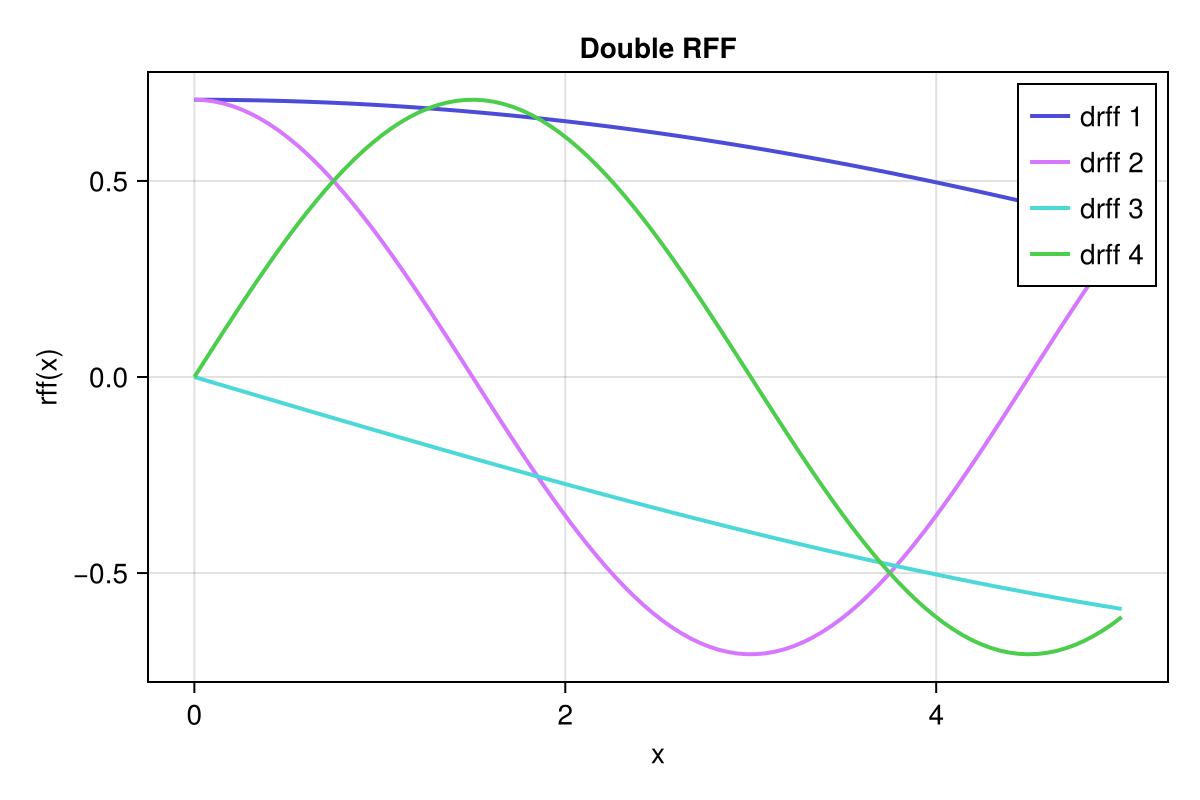

In [6]:
f = Figure(; size=(600, 400))
ax = Axis(f[1, 1]; xlabel="x", ylabel="rff(x)", title="Double RFF")
series!(ax, x, reduce(hcat, drff.(x)); labels=["drff $i" for i in 1:4])
axislegend(ax; position=:rt)
f

## Approximating a kernel
We can use the feature functions to approximate a kernel,
using the kernel trick
$$
    k(x, x') = \langle \varphi(x), \varphi(x') \rangle
$$
Comparing with the Kernel Densities example, we note that this
is effective a Monte Carlo approximation of inverse Fourier transform.

To demonstrate that this works, we generate some feature functions and
see how well they recover the kernel.

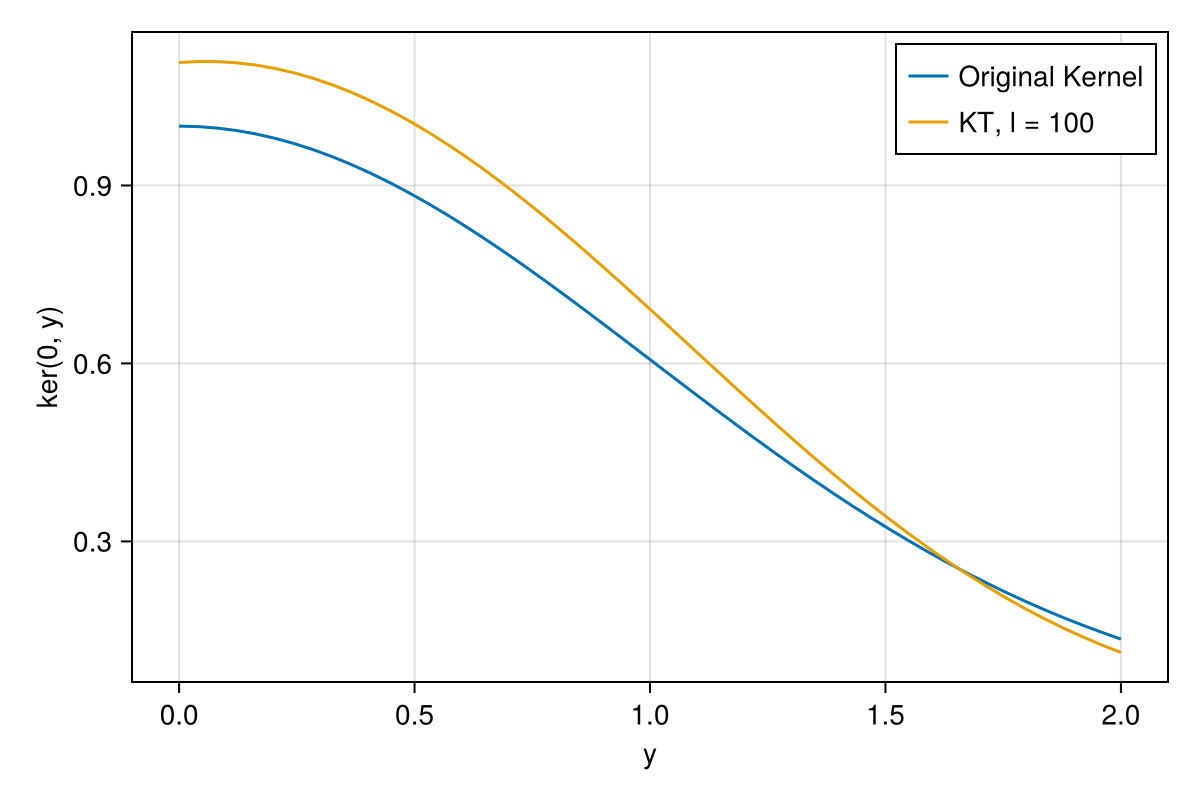

In [7]:
rff = ShiftedRFF(S, 100)
kt(x, y) = dot(rff(x), rff(y))

x_plot = range(0, 2; length=50)
f = Figure(; size=(600, 400))
ax = Axis(f[1, 1]; xlabel="y", ylabel="ker(0, y)", title="")
lines!(ax, x_plot, ker.(0, x_plot); label="Original Kernel")
lines!(ax, x_plot, kt.(0, x_plot); label="KT, l = 100")
axislegend(ax)
f

Clearly this is not quite correct, and we can quantify this
by checking the error.

In [8]:
norm(ker.(0, x_plot) .- kt.(0, x_plot))

0.5981992704193174

Fortunately, we can improve the approximation by using more features,

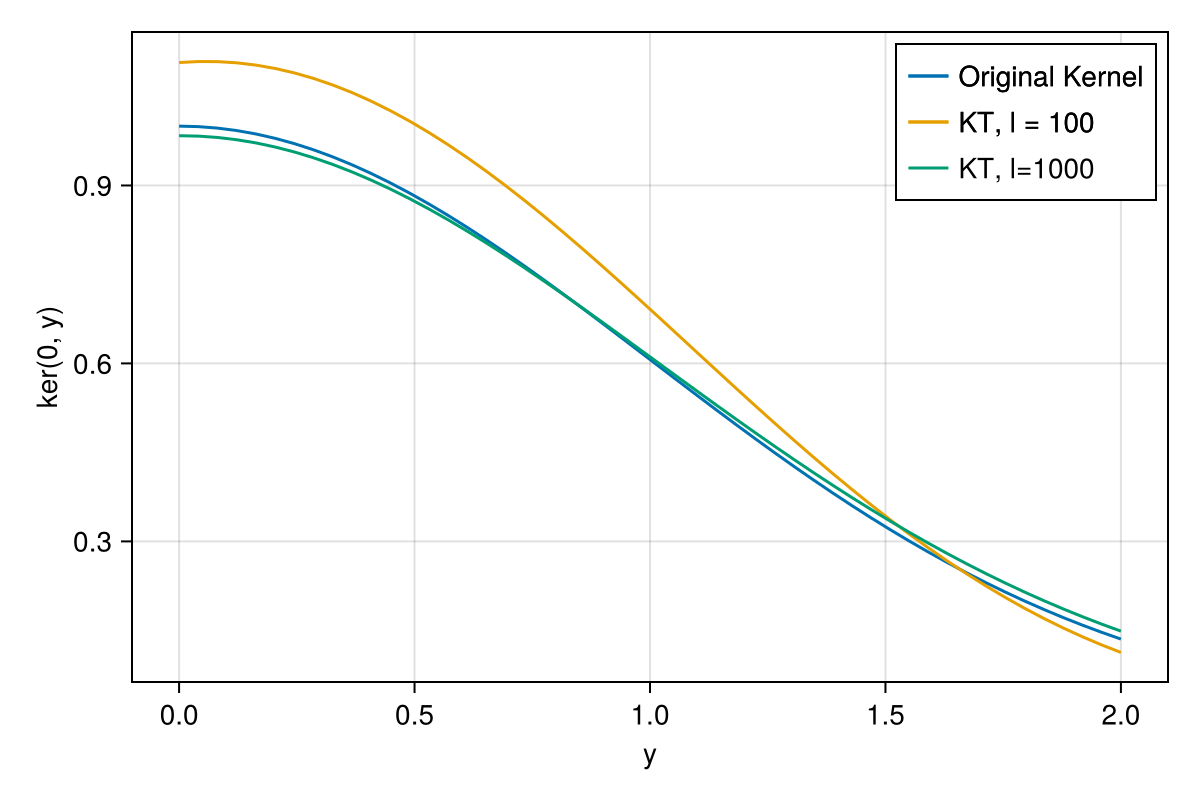

In [9]:
rff1000 = ShiftedRFF(S, 5000)
kt1000(x, y) = dot(rff1000(x), rff1000(y))

lines!(ax, x_plot, kt1000.(0, x_plot); label="KT, l=1000")
axislegend(ax)
f

which also reduces the error.

In [10]:
norm(ker.(0, x_plot) .- kt1000.(0, x_plot))

0.08264467536433352

## Comparing the RFFs
In the section above we used the `ShiftedRFF` feature function, but what about the `DoubleRFF`?
Let's compare the two!. First we define some helper functions.

In [11]:
function kt_error(ker, rff, S, l, x)
    rff = rff(S, l)
    kt(x, y) = dot(rff(x), rff(y))
    return norm(ker.(0, x) .- kt.(0, x))
end

function mean_kt_error(ker, rff, S, l, x, n)
    return mean([kt_error(ker, rff, S, l, x) for _ in 1:n])
end
nothing # hide

Now we compute the mean error for both feature functions, using 100 features when recovering
the original kernel. To reduce the effect of randomness, we average over 5000 runs.

In [12]:
srff_err = mean_kt_error(ker, ShiftedRFF, S, 100, x_plot, 5000)

0.5172357811364618

In [13]:
drff_err = mean_kt_error(ker, DoubleRFF, S, 100, x_plot, 5000)

0.38844224378063663

We see that the double rff has a lower average error. This
continues to hold for higher number of features.

In [14]:
srff_err = mean_kt_error(ker, ShiftedRFF, S, 1000, x_plot, 5000)

0.16641427025939007

In [15]:
drff_err = mean_kt_error(ker, DoubleRFF, S, 1000, x_plot, 5000)

0.12305498951692075

## Comparison, continued
Lastly, we show a loglog plot of the mean error as a function
of the number of features.
We see that both feature functions have the order of error scaling,
but the DualRFF error has a small offset, resulting in a lower error.
This is especially impactful for a small number of features.

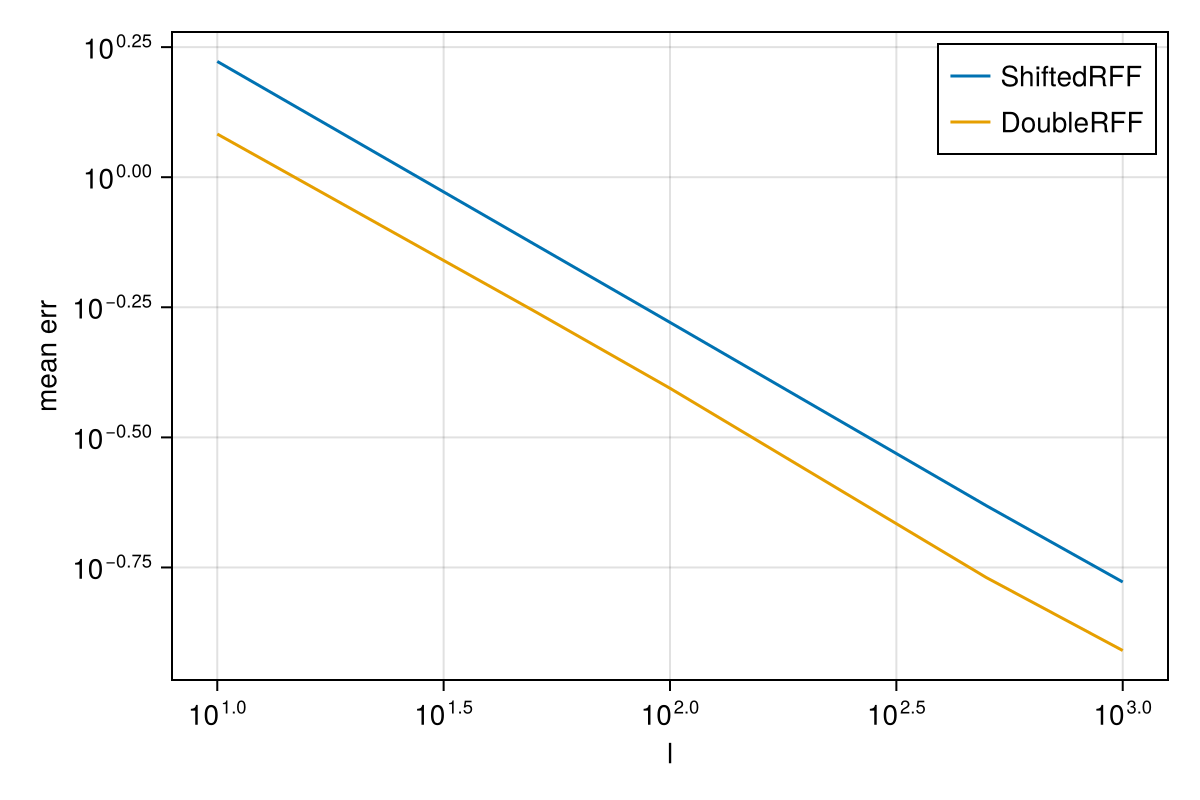

In [16]:
l_plot = [10, 50, 100, 500, 1000]
srff_comp = [mean_kt_error(ker, ShiftedRFF, S, l, x_plot, 5000) for l in l_plot]
drff_comp = [mean_kt_error(ker, DoubleRFF, S, l, x_plot, 5000) for l in l_plot]

f = Figure(; size=(600, 400))
ax = Axis(f[1, 1]; xlabel="l", ylabel="mean err", title="", xscale=log10, yscale=log10)
lines!(ax, l_plot, srff_comp; label="ShiftedRFF")
lines!(ax, l_plot, drff_comp; label="DoubleRFF")
axislegend(ax)
f

<hr />
<h6>Package and system information</h6>
<details>
<summary>Package information (click to expand)</summary>
<pre>
Status &#96;~/work/KernelSpectralDensities.jl/KernelSpectralDensities.jl/examples/2-features/Project.toml&#96;
  &#91;13f3f980&#93; CairoMakie v0.13.1
  &#91;0b91fe84&#93; DisplayAs v0.1.6
  &#91;027d52a2&#93; KernelSpectralDensities v0.2.0 &#96;/home/runner/work/KernelSpectralDensities.jl/KernelSpectralDensities.jl#main&#96;
  &#91;98b081ad&#93; Literate v2.20.1
  &#91;2913bbd2&#93; StatsBase v0.34.4
</pre>
To reproduce this notebook's package environment, you can
<a href="./Manifest.toml">
download the full Manifest.toml</a>.
</details>
<details>
<summary>System information (click to expand)</summary>
<pre>
Julia Version 1.11.3
Commit d63adeda50d &#40;2025-01-21 19:42 UTC&#41;
Build Info:
  Official https://julialang.org/ release
Platform Info:
  OS: Linux &#40;x86_64-linux-gnu&#41;
  CPU: 4 × AMD EPYC 7763 64-Core Processor
  WORD_SIZE: 64
  LLVM: libLLVM-16.0.6 &#40;ORCJIT, znver3&#41;
Threads: 1 default, 0 interactive, 1 GC &#40;on 4 virtual cores&#41;
Environment:
  JULIA_PKG_SERVER_REGISTRY_PREFERENCE &#61; eager
  JULIA_LOAD_PATH &#61; :/home/runner/.julia/packages/JuliaGPsDocs/7M86H/src
</pre>
</details>

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*